In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, savefig
import matplotlib.colors
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy.matlib
import os
from datetime import datetime, timedelta
from tqdm.autonotebook import tqdm 
import fnmatch

/tmp/ipykernel_8546/1223172723.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
#load pr timeseries
sfcWind = xr.open_dataset('/home/jovyan/CMIP6cf/output/timeseries/sfcWind_tgs/MRI-ESM2-0/MRI-ESM2-0_gn_day_ssp585.nc').sel(member_id='r1i1p1f1')
pr = xr.open_dataset('/home/jovyan/CMIP6cf/output/timeseries/pr_tgs/MRI-ESM2-0/MRI-ESM2-0_gn_day_ssp585.nc').sel(member_id='r1i1p1f1')

pr_hist = pr.sel(time=slice('1981','2010'))
pr_fut = pr.sel(time=slice('2070','2099'))

sfcWind_hist = sfcWind.sel(time=slice('1981','2010'))
sfcWind_fut = sfcWind.sel(time=slice('2070','2099'))

sfcWind_peaks_hist = sfcWind_hist.where(sfcWind_hist.sfcWind>sfcWind_hist.sfcWind.quantile(.98,dim='time'))
pr_peaks_hist = pr_hist.where(pr_hist.pr>pr_hist.pr.quantile(.98,dim='time'))

sfcWind_peaks_fut = sfcWind_fut.where(sfcWind_fut.sfcWind>sfcWind_fut.sfcWind.quantile(.98,dim='time'))
pr_peaks_fut = pr_fut.where(pr_fut.pr>pr_fut.pr.quantile(.98,dim='time'))

#sfcWind_peaks_hist = sfcWind_peaks_hist.where(np.mod(sfcWind_peaks_hist.time.dt.month,12)<3)

#pr_peaks_hist = pr_peaks_hist.where(np.mod(pr_peaks_hist.time.dt.month,12)<3)
#pr_peaks_fut = pr_fut.where(pr_fut>pr_fut.quantile(.98,dim='time'))

In [3]:
sfcWind_peaks_hist['has_track'] = np.nan*sfcWind_peaks_hist.sfcWind

for itg,tg in tqdm(enumerate(sfcWind_peaks_hist.tg.values)):
    tg_lon = sfcWind_peaks_hist.sel(tg=tg).lon.values
    tg_lat = sfcWind_peaks_hist.sel(tg=tg).lat.values
    
    wind_peaks = sfcWind_peaks_hist.sfcWind.sel(tg=tg)
    wind_peaks = wind_peaks.where(np.mod(wind_peaks.time.dt.month,12)<3) #DJF
    wind_peaks = wind_peaks.dropna(dim='time')
    
    for wind_peak in wind_peaks:
        y0 = wind_peak.time.dt.year.values - (np.mod(wind_peak.time.dt.month.values,12)>0).astype(int)
        d6h = (wind_peak.time.values - np.array(datetime(y0,12,1,0,0,0)).astype("datetime64[ns]")).astype('timedelta64[h]')/6
        peak_times = np.arange(d6h-2,d6h+3).astype('int')
        
        peak_has_track = 0
        
        if y0<2015:
            path = '/home/jovyan/CMIP6cf/Priestley_tracks/historical_npy/'
        else:
            path = '/home/jovyan/CMIP6cf/Priestley_tracks/ssp585_npy/'    
        try:    
            tracks = np.load(os.path.join(path,fnmatch.filter(os.listdir(path),'*_'+str(y0)+'*')[0]),allow_pickle=True)
        except:
            continue
        for t,track in enumerate(tracks):
            if len(np.intersect1d(peak_times,track[:,0]))==0:
                continue
            xy,idx,idy =  np.intersect1d(peak_times,track[:,0],return_indices=True)
            
            track_lons = track[idy,1]
            track_lats = track[idy,2]
            
            dists = 2*np.arcsin( np.sqrt(
                            np.sin( (np.pi/180) * 0.5*(tg_lat-track_lats) )**2 +
                            np.cos((np.pi/180)*track_lats)*np.cos((np.pi/180)*tg_lat)*np.sin((np.pi/180)*0.5*(tg_lon-track_lons))**2) )
            
            
            
            peak_has_track = (dists<(500/6371)).any()
            
            if peak_has_track:
                sfcWind_peaks_hist['has_track'][sfcWind_peaks_hist.time==wind_peak.time,itg] = 1
                break

0it [00:00, ?it/s]

In [4]:
sfcWind_peaks_fut['has_track'] = np.nan*sfcWind_peaks_fut.sfcWind

for itg,tg in tqdm(enumerate(sfcWind_peaks_fut.tg.values)):
    tg_lon = sfcWind_peaks_fut.sel(tg=tg).lon.values
    tg_lat = sfcWind_peaks_fut.sel(tg=tg).lat.values
    
    wind_peaks = sfcWind_peaks_fut.sfcWind.sel(tg=tg)
    wind_peaks = wind_peaks.where(np.mod(wind_peaks.time.dt.month,12)<3) #DJF
    wind_peaks = wind_peaks.dropna(dim='time')
    
    for wind_peak in wind_peaks:
        y0 = wind_peak.time.dt.year.values - (np.mod(wind_peak.time.dt.month.values,12)>0).astype(int)
        d6h = (wind_peak.time.values - np.array(datetime(y0,12,1,0,0,0)).astype("datetime64[ns]")).astype('timedelta64[h]')/6
        peak_times = np.arange(d6h-2,d6h+3).astype('int')
        
        peak_has_track = 0
        
        if y0<2015:
            path = '/home/jovyan/CMIP6cf/Priestley_tracks/historical_npy/'
        else:
            path = '/home/jovyan/CMIP6cf/Priestley_tracks/ssp585_npy/'    
        try:    
            tracks = np.load(os.path.join(path,fnmatch.filter(os.listdir(path),'*_'+str(y0)+'*')[0]),allow_pickle=True)
        except:
            continue
        for t,track in enumerate(tracks):
            if len(np.intersect1d(peak_times,track[:,0]))==0:
                continue
            xy,idx,idy =  np.intersect1d(peak_times,track[:,0],return_indices=True)
            
            track_lons = track[idy,1]
            track_lats = track[idy,2]
            
            dists = 2*np.arcsin( np.sqrt(
                            np.sin( (np.pi/180) * 0.5*(tg_lat-track_lats) )**2 +
                            np.cos((np.pi/180)*track_lats)*np.cos((np.pi/180)*tg_lat)*np.sin((np.pi/180)*0.5*(tg_lon-track_lons))**2) )
            
            
            
            peak_has_track = (dists<(500/6371)).any()
            
            if peak_has_track:
                sfcWind_peaks_fut['has_track'][sfcWind_peaks_fut.time==wind_peak.time,itg] = 1
                break

0it [00:00, ?it/s]

In [5]:
pr_peaks_hist['has_track'] = np.nan*pr_peaks_hist.pr

for itg,tg in tqdm(enumerate(pr_peaks_hist.tg.values)):
    tg_lon = pr_peaks_hist.sel(tg=tg).lon.values
    tg_lat = pr_peaks_hist.sel(tg=tg).lat.values
    
    pr_peaks = pr_peaks_hist.pr.sel(tg=tg)
    pr_peaks = pr_peaks.where(np.mod(pr_peaks.time.dt.month,12)<3) #DJF
    pr_peaks = pr_peaks.dropna(dim='time')
    
    for pr_peak in pr_peaks:
        y0 = pr_peak.time.dt.year.values - (np.mod(pr_peak.time.dt.month.values,12)>0).astype(int)
        d6h = (pr_peak.time.values - np.array(datetime(y0,12,1,0,0,0)).astype("datetime64[ns]")).astype('timedelta64[h]')/6
        peak_times = np.arange(d6h-2,d6h+3).astype('int')
        
        peak_has_track = 0
        
        if y0<2015:
            path = '/home/jovyan/CMIP6cf/Priestley_tracks/historical_npy/'
        else:
            path = '/home/jovyan/CMIP6cf/Priestley_tracks/ssp585_npy/'    
        try:    
            tracks = np.load(os.path.join(path,fnmatch.filter(os.listdir(path),'*_'+str(y0)+'*')[0]),allow_pickle=True)
        except:
            continue
        for t,track in enumerate(tracks):
            if len(np.intersect1d(peak_times,track[:,0]))==0:
                continue
            xy,idx,idy =  np.intersect1d(peak_times,track[:,0],return_indices=True)
            
            track_lons = track[idy,1]
            track_lats = track[idy,2]
            
            dists = 2*np.arcsin( np.sqrt(
                            np.sin( (np.pi/180) * 0.5*(tg_lat-track_lats) )**2 +
                            np.cos((np.pi/180)*track_lats)*np.cos((np.pi/180)*tg_lat)*np.sin((np.pi/180)*0.5*(tg_lon-track_lons))**2) )
            
            
            peak_has_track = (dists<(500/6371)).any()
            
            if peak_has_track:
                pr_peaks_hist['has_track'][pr_peaks_hist.time==pr_peak.time,itg] = 1
                break

0it [00:00, ?it/s]

In [6]:
pr_peaks_fut['has_track'] = np.nan*pr_peaks_fut.pr

for itg,tg in tqdm(enumerate(pr_peaks_fut.tg.values)):
    tg_lon = pr_peaks_fut.sel(tg=tg).lon.values
    tg_lat = pr_peaks_fut.sel(tg=tg).lat.values
    
    pr_peaks = pr_peaks_fut.pr.sel(tg=tg)
    pr_peaks = pr_peaks.where(np.mod(pr_peaks.time.dt.month,12)<3) #DJF
    pr_peaks = pr_peaks.dropna(dim='time')
    
    for pr_peak in pr_peaks:
        y0 = pr_peak.time.dt.year.values - (np.mod(pr_peak.time.dt.month.values,12)>0).astype(int)
        d6h = (pr_peak.time.values - np.array(datetime(y0,12,1,0,0,0)).astype("datetime64[ns]")).astype('timedelta64[h]')/6
        peak_times = np.arange(d6h-2,d6h+3).astype('int')
        
        peak_has_track = 0
        
        if y0<2015:
            path = '/home/jovyan/CMIP6cf/Priestley_tracks/historical_npy/'
        else:
            path = '/home/jovyan/CMIP6cf/Priestley_tracks/ssp585_npy/'    
        try:    
            tracks = np.load(os.path.join(path,fnmatch.filter(os.listdir(path),'*_'+str(y0)+'*')[0]),allow_pickle=True)
        except:
            continue
        for t,track in enumerate(tracks):
            if len(np.intersect1d(peak_times,track[:,0]))==0:
                continue
            xy,idx,idy =  np.intersect1d(peak_times,track[:,0],return_indices=True)
            
            track_lons = track[idy,1]
            track_lats = track[idy,2]
            
            dists = 2*np.arcsin( np.sqrt(
                            np.sin( (np.pi/180) * 0.5*(tg_lat-track_lats) )**2 +
                            np.cos((np.pi/180)*track_lats)*np.cos((np.pi/180)*tg_lat)*np.sin((np.pi/180)*0.5*(tg_lon-track_lons))**2) )
            
            
            peak_has_track = (dists<(500/6371)).any()
            
            if peak_has_track:
                pr_peaks_fut['has_track'][pr_peaks_fut.time==pr_peak.time,itg] = 1
                break

0it [00:00, ?it/s]

Text(0.5, 1.0, 'cooc diff')

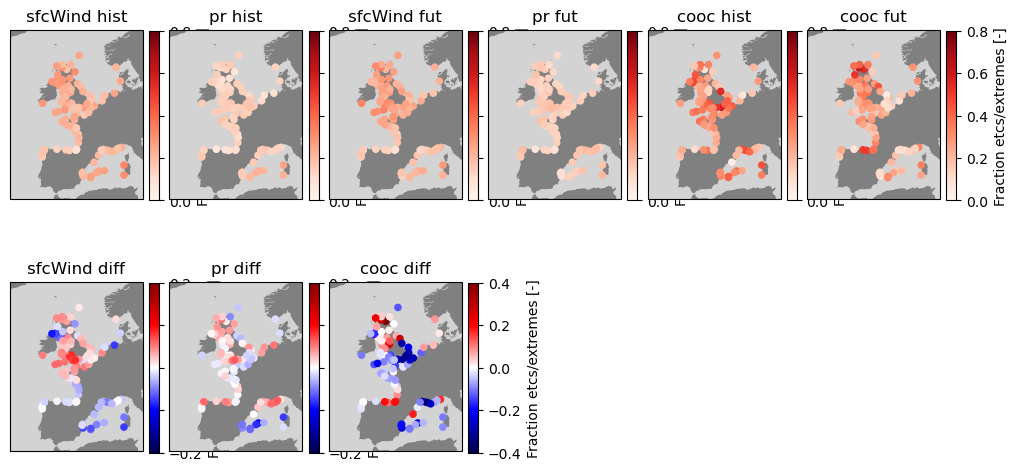

In [7]:
import cartopy
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


fig=plt.figure(figsize=(12,6)) #generate figure  
gs = fig.add_gridspec(2,6)


#1991-2020
ax = plt.subplot(gs[0,0],projection=ccrs.Robinson(central_longitude=0))

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

sc=ax.scatter(sfcWind_peaks_hist.lon,sfcWind_peaks_hist.lat,c=sfcWind_peaks_hist.has_track.sum(dim='time')/np.isfinite(sfcWind_peaks_hist.sfcWind).sum(dim='time'),cmap='Reds',vmin=0,vmax=.8,s=20,transform=ccrs.PlateCarree(),zorder=3)
ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(1.1, 0.035,.075,1),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='vertical',label='Fraction etcs/extremes [-]')
ax.set_title('sfcWind hist')


#1991-2020
ax = plt.subplot(gs[0,1],projection=ccrs.Robinson(central_longitude=0))

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

sc=ax.scatter(pr_peaks_hist.lon,pr_peaks_hist.lat,c=pr_peaks_hist.has_track.sum(dim='time')/np.isfinite(pr_peaks_hist.pr).sum(dim='time'),cmap='Reds',vmin=0,vmax=.8,s=20,transform=ccrs.PlateCarree(),zorder=3)
ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(1.1, 0.035,.075,1),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='vertical',label='Fraction etcs/extremes [-]')
ax.set_title('pr hist')


ax = plt.subplot(gs[0,2],projection=ccrs.Robinson(central_longitude=0))

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

sc=ax.scatter(sfcWind_peaks_fut.lon,sfcWind_peaks_fut.lat,c=sfcWind_peaks_fut.has_track.sum(dim='time')/np.isfinite(sfcWind_peaks_fut.sfcWind).sum(dim='time'),cmap='Reds',vmin=0,vmax=.8,s=20,transform=ccrs.PlateCarree(),zorder=3)
ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(1.1, 0.035,.075,1),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='vertical',label='Fraction etcs/extremes [-]')
ax.set_title('sfcWind fut')


#1991-2020
ax = plt.subplot(gs[0,3],projection=ccrs.Robinson(central_longitude=0))

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

sc=ax.scatter(pr_peaks_fut.lon,pr_peaks_fut.lat,c=pr_peaks_fut.has_track.sum(dim='time')/np.isfinite(pr_peaks_fut.pr).sum(dim='time'),cmap='Reds',vmin=0,vmax=.8,s=20,transform=ccrs.PlateCarree(),zorder=3)
ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(1.1, 0.035,.075,1),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='vertical',label='Fraction etcs/extremes [-]')
ax.set_title('pr fut')


ax = plt.subplot(gs[0,4],projection=ccrs.Robinson(central_longitude=0))

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

sc=ax.scatter(pr_peaks_fut.lon,pr_peaks_fut.lat,c=sfcWind_peaks_hist.has_track.where(pr_peaks_hist.has_track==1).sum(dim='time')/np.isfinite(sfcWind_peaks_hist.sfcWind.where(np.isfinite(pr_peaks_hist.pr))).sum(dim='time'),cmap='Reds',vmin=0,vmax=.8,s=20,transform=ccrs.PlateCarree(),zorder=3)
ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(1.1, 0.035,.075,1),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='vertical',label='Fraction etcs/extremes [-]')
ax.set_title('cooc hist')


ax = plt.subplot(gs[0,5],projection=ccrs.Robinson(central_longitude=0))

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

sc=ax.scatter(pr_peaks_fut.lon,pr_peaks_fut.lat,c=sfcWind_peaks_fut.has_track.where(pr_peaks_fut.has_track==1).sum(dim='time')/np.isfinite(sfcWind_peaks_fut.sfcWind.where(np.isfinite(pr_peaks_fut.pr))).sum(dim='time'),cmap='Reds',vmin=0,vmax=.8,s=20,transform=ccrs.PlateCarree(),zorder=3)
ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(1.1, 0.035,.075,1),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='vertical',label='Fraction etcs/extremes [-]')
ax.set_title('cooc fut')











ax = plt.subplot(gs[1,0],projection=ccrs.Robinson(central_longitude=0))

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

sc=ax.scatter(sfcWind_peaks_hist.lon,sfcWind_peaks_hist.lat,c=sfcWind_peaks_fut.has_track.sum(dim='time')/np.isfinite(sfcWind_peaks_fut.sfcWind).sum(dim='time')-sfcWind_peaks_hist.has_track.sum(dim='time')/np.isfinite(sfcWind_peaks_hist.sfcWind).sum(dim='time'),cmap='seismic',vmin=-.2,vmax=.2,s=20,transform=ccrs.PlateCarree(),zorder=3)
ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(1.1, 0.035,.075,1),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='vertical',label='Fraction etcs/extremes [-]')
ax.set_title('sfcWind diff')


#1991-2020
ax = plt.subplot(gs[1,1],projection=ccrs.Robinson(central_longitude=0))

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

sc=ax.scatter(pr_peaks_hist.lon,pr_peaks_hist.lat,c=pr_peaks_fut.has_track.sum(dim='time')/np.isfinite(pr_peaks_fut.pr).sum(dim='time')-pr_peaks_hist.has_track.sum(dim='time')/np.isfinite(pr_peaks_hist.pr).sum(dim='time'),cmap='seismic',vmin=-.2,vmax=.2,s=20,transform=ccrs.PlateCarree(),zorder=3)
ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(1.1, 0.035,.075,1),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='vertical',label='Fraction etcs/extremes [-]')
ax.set_title('pr diff')


ax = plt.subplot(gs[1,2],projection=ccrs.Robinson(central_longitude=0))

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

sc=ax.scatter(pr_peaks_hist.lon,pr_peaks_hist.lat,c=sfcWind_peaks_fut.has_track.where(pr_peaks_fut.has_track==1).sum(dim='time')/np.isfinite(sfcWind_peaks_fut.sfcWind.where(np.isfinite(pr_peaks_fut.pr))).sum(dim='time')-sfcWind_peaks_hist.has_track.where(pr_peaks_hist.has_track==1).sum(dim='time')/np.isfinite(sfcWind_peaks_hist.sfcWind.where(np.isfinite(pr_peaks_hist.pr))).sum(dim='time'),cmap='seismic',vmin=-.4,vmax=.4,s=20,transform=ccrs.PlateCarree(),zorder=3)
ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(1.1, 0.035,.075,1),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='vertical',label='Fraction etcs/extremes [-]')
ax.set_title('cooc diff')

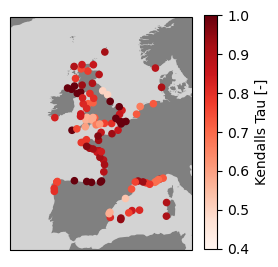

In [11]:
import cartopy
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


fig=plt.figure(figsize=(8,8)) #generate figure  
gs = fig.add_gridspec(1,3)


#1991-2020
ax = plt.subplot(gs[0,0],projection=ccrs.Robinson(central_longitude=0))

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

sc=ax.scatter(pr_peaks_hist.lon,pr_peaks_hist.lat,c=sfcWind_peaks_hist.has_track.where(pr_peaks_hist.has_track==1).sum(dim='time')/np.isfinite(sfcWind_peaks_hist.sfcWind.where(np.isfinite(pr_peaks_hist.pr))).sum(dim='time'),cmap='Reds',vmin=0.4,vmax=1,s=20,transform=ccrs.PlateCarree(),zorder=3)
ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(1.1, 0.035,.075,1),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='vertical',label='Kendalls Tau [-]')

In [141]:
track_lats

array([44.216724, 45.763515, 46.707607, 47.565727, 46.833797])

In [106]:
d6h = (wind_peak.time.values - np.array(datetime(y0,12,1,0,0,0)).astype("datetime64[ns]")).astype('timedelta64[h]')/6
peak_times = np.arange(d6h-2,d6h+3).astype('int')

In [142]:
tg_lon

array(-5.698)

In [143]:
tg_lat

array(43.558)

In [101]:



        if os.path.exists(file):
            with open(file, "r" ) as source:

                for t,heading_and_lines in enumerate(group_by_heading( source )): #for each storm track

                    heading= heading_and_lines[0]
                    lines = heading_and_lines[1:-1]

                    if t>0:
                        times = np.array([float(k.split(' ')[0]) for k in lines])
                        track_lons = np.array([((float(k.split(' ')[1]) +180)%360)-180 for k in lines])
                        track_lats = np.array([float(k.split(' ')[2]) for k in lines])

                        distances = 2*np.arcsin( np.sqrt(
                            np.sin( (np.pi/180) * 0.5*(test.lat.values-track_lats) )**2 +
                            np.cos((np.pi/180)*track_lats)*np.cos((np.pi/180)*test.lat.values)*np.sin((np.pi/180)*0.5*(test.lon.values-track_lons))**2) ) #test distances track to 0, 50

                        '''
                        qlat = np.transpose(np.matlib.repmat(qLATS.flatten(),len(track_lats),1))
                        lat = np.matlib.repmat(track_lats,len(qLATS.flatten()),1)

                        qlon = np.transpose(np.matlib.repmat(qLONS.flatten(),len(track_lons),1))
                        lon = np.matlib.repmat(track_lons,len(qLONS.flatten()),1)

                        #calculate distances between track coordinates and grid points
                        distances = 2*np.arcsin( np.sqrt(
                            np.sin( (np.pi/180) * 0.5*(qlat-lat) )**2 +
                            np.cos((np.pi/180)*lat)*np.cos((np.pi/180)*qlat)*np.sin((np.pi/180)*0.5*(qlon-lon))**2) ) #test distances track to 0, 50
                        '''
                        #print(distances)
                        #t0 = np.min(np.matlib.repmat(times,len(qLONS.flatten()),1)[distances<=(2*np.pi*5/360)])
                        #t1 = np.max(np.matlib.repmat(times,len(qLONS.flatten()),1)[distances<=(2*np.pi*5/360)])

                        conds = np.where( (distances<=(2*np.pi*10/360)) & (times>=timesteps[0]) & (times<=timesteps[-1]) )[0]
                        if len(conds)>0:
                            hist_tracks_per_extreme[itg,p] += 1

numpy.timedelta64(238,'h')

In [89]:
tracks[0][:,8]

IndexError: index 8 is out of bounds for axis 1 with size 7

In [ ]:
for itg,tg in tqdm(enumerate(sfcWind_peaks_hist.tg.values)):
    wind_peaks = sfcWind_peaks_hist.sel(tg=tg)
    wind_peaks = wind_peaks.where(np.mod(wind.peaks.time.dt.month,12)>3)
    
    
    test = pr_peaks_fut.sel(tg=tg).dropna(dim='time')
    
    for p,peak in enumerate(test):
        if (peak.time.dt.month>2) and (peak.time.dt.month<12):
            continue
        else:
            fut_peak_in_winter[itg] += 1
            year=peak.time.dt.year.values
            if peak.time.dt.month.values == 12:
                if year<2015:
                    file = '/home/jovyan/CMIP6cf/Priestley_tracks/historical/MRI-ESM2-0/MRI-ESM2-0_'+str(year)+str(year+1)+'_TRACKS_FILTERED_pos.addmslp'
                else:
                    file = '/home/jovyan/CMIP6cf/Priestley_tracks/ssp585/MRI-ESM2-0/MRI-ESM2-0_'+str(year)+str(year+1)+'_TRACKS_FILTERED_pos.addmslp'
                ref = datetime.datetime(year,12,1,0,0,0)
            else:
                if year<2015:
                    file = '/home/jovyan/CMIP6cf/Priestley_tracks/historical/MRI-ESM2-0/MRI-ESM2-0_'+str(year-1)+str(year)+'_TRACKS_FILTERED_pos.addmslp'
                else:
                    file = '/home/jovyan/CMIP6cf/Priestley_tracks/ssp585/MRI-ESM2-0/MRI-ESM2-0_'+str(year-1)+str(year)+'_TRACKS_FILTERED_pos.addmslp'
                ref = datetime.datetime(year-1,12,1,0,0,0)
            d6h = (peak.time.values - np.datetime64(ref)).astype('timedelta64[h]')/6
            timesteps = np.arange(d6h-2,d6h+3).astype('int')


        if os.path.exists(file):
            with open(file, "r" ) as source:

                for t,heading_and_lines in enumerate(group_by_heading( source )): #for each storm track

                    heading= heading_and_lines[0]
                    lines = heading_and_lines[1:-1]

                    if t>0:
                        times = np.array([float(k.split(' ')[0]) for k in lines])
                        track_lons = np.array([((float(k.split(' ')[1]) +180)%360)-180 for k in lines])
                        track_lats = np.array([float(k.split(' ')[2]) for k in lines])

                        distances = 2*np.arcsin( np.sqrt(
                            np.sin( (np.pi/180) * 0.5*(test.lat.values-track_lats) )**2 +
                            np.cos((np.pi/180)*track_lats)*np.cos((np.pi/180)*test.lat.values)*np.sin((np.pi/180)*0.5*(test.lon.values-track_lons))**2) ) #test distances track to 0, 50

                        '''
                        qlat = np.transpose(np.matlib.repmat(qLATS.flatten(),len(track_lats),1))
                        lat = np.matlib.repmat(track_lats,len(qLATS.flatten()),1)

                        qlon = np.transpose(np.matlib.repmat(qLONS.flatten(),len(track_lons),1))
                        lon = np.matlib.repmat(track_lons,len(qLONS.flatten()),1)

                        #calculate distances between track coordinates and grid points
                        distances = 2*np.arcsin( np.sqrt(
                            np.sin( (np.pi/180) * 0.5*(qlat-lat) )**2 +
                            np.cos((np.pi/180)*lat)*np.cos((np.pi/180)*qlat)*np.sin((np.pi/180)*0.5*(qlon-lon))**2) ) #test distances track to 0, 50
                        '''
                        #print(distances)
                        #t0 = np.min(np.matlib.repmat(times,len(qLONS.flatten()),1)[distances<=(2*np.pi*5/360)])
                        #t1 = np.max(np.matlib.repmat(times,len(qLONS.flatten()),1)[distances<=(2*np.pi*5/360)])

                        conds = np.where( (distances<=(2*np.pi*5/360)) & (times>=timesteps[0]) & (times<=timesteps[-1]) )[0]
                        if len(conds)>0:
                            fut_tracks_per_extreme[itg,p] += 1
                 


In [130]:
tracks[0][:,0]

array([12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.,
       25., 26., 27., 28.])

In [117]:
itrack

943

In [113]:
track_times

array(['1952-02-25T00:00:00.000000000', '1952-02-25T06:00:00.000000000',
       '1952-02-25T12:00:00.000000000', '1952-02-25T18:00:00.000000000',
       '1952-02-26T00:00:00.000000000', '1952-02-26T06:00:00.000000000',
       '1952-02-26T12:00:00.000000000', '1952-02-26T18:00:00.000000000',
       '1952-02-27T00:00:00.000000000', '1952-02-27T06:00:00.000000000',
       '1952-02-27T12:00:00.000000000', '1952-02-27T18:00:00.000000000',
       '1952-02-28T00:00:00.000000000', '1952-02-28T06:00:00.000000000',
       '1952-02-28T12:00:00.000000000', '1952-02-28T18:00:00.000000000',
       '1952-02-29T00:00:00.000000000', '1952-02-29T06:00:00.000000000',
       '1952-02-29T12:00:00.000000000', '1952-02-29T18:00:00.000000000'],
      dtype='datetime64[ns]')

In [102]:
time[92051]

numpy.datetime64('2013-12-02T18:00:00.000000000')

array(['1950-12-01T00:00:00.000000000', '1950-12-01T06:00:00.000000000',
       '1950-12-01T12:00:00.000000000', ...,
       '2014-02-28T06:00:00.000000000', '2014-02-28T12:00:00.000000000',
       '2014-02-28T18:00:00.000000000'], dtype='datetime64[ns]')

In [83]:
end_year

'2014'

In [63]:
times[3]

datetime.datetime(1995, 2, 23, 12, 0)

In [6]:
fut_tracks_per_extreme = np.zeros((len(pr_peaks_hist.tg),len(pr_peaks_fut.isel(tg=0).dropna(dim='time'))))
fut_peak_in_winter = np.zeros(len(pr_peaks_hist.tg))
for itg,tg in enumerate(pr_peaks_hist.tg.values):
    print(itg)
    test = pr_peaks_fut.sel(tg=tg).dropna(dim='time')
    
    for p,peak in enumerate(test):
        if (peak.time.dt.month>2) and (peak.time.dt.month<12):
            continue
        else:
            fut_peak_in_winter[itg] += 1
            year=peak.time.dt.year.values
            if peak.time.dt.month.values == 12:
                if year<2015:
                    file = '/home/jovyan/CMIP6cf/Priestley_tracks/historical/MRI-ESM2-0/MRI-ESM2-0_'+str(year)+str(year+1)+'_TRACKS_FILTERED_pos.addmslp'
                else:
                    file = '/home/jovyan/CMIP6cf/Priestley_tracks/ssp585/MRI-ESM2-0/MRI-ESM2-0_'+str(year)+str(year+1)+'_TRACKS_FILTERED_pos.addmslp'
                ref = datetime.datetime(year,12,1,0,0,0)
            else:
                if year<2015:
                    file = '/home/jovyan/CMIP6cf/Priestley_tracks/historical/MRI-ESM2-0/MRI-ESM2-0_'+str(year-1)+str(year)+'_TRACKS_FILTERED_pos.addmslp'
                else:
                    file = '/home/jovyan/CMIP6cf/Priestley_tracks/ssp585/MRI-ESM2-0/MRI-ESM2-0_'+str(year-1)+str(year)+'_TRACKS_FILTERED_pos.addmslp'
                ref = datetime.datetime(year-1,12,1,0,0,0)
            d6h = (peak.time.values - np.datetime64(ref)).astype('timedelta64[h]')/6
            timesteps = np.arange(d6h-2,d6h+3).astype('int')


        if os.path.exists(file):
            with open(file, "r" ) as source:

                for t,heading_and_lines in enumerate(group_by_heading( source )): #for each storm track

                    heading= heading_and_lines[0]
                    lines = heading_and_lines[1:-1]

                    if t>0:
                        times = np.array([float(k.split(' ')[0]) for k in lines])
                        track_lons = np.array([((float(k.split(' ')[1]) +180)%360)-180 for k in lines])
                        track_lats = np.array([float(k.split(' ')[2]) for k in lines])

                        distances = 2*np.arcsin( np.sqrt(
                            np.sin( (np.pi/180) * 0.5*(test.lat.values-track_lats) )**2 +
                            np.cos((np.pi/180)*track_lats)*np.cos((np.pi/180)*test.lat.values)*np.sin((np.pi/180)*0.5*(test.lon.values-track_lons))**2) ) #test distances track to 0, 50

                        '''
                        qlat = np.transpose(np.matlib.repmat(qLATS.flatten(),len(track_lats),1))
                        lat = np.matlib.repmat(track_lats,len(qLATS.flatten()),1)

                        qlon = np.transpose(np.matlib.repmat(qLONS.flatten(),len(track_lons),1))
                        lon = np.matlib.repmat(track_lons,len(qLONS.flatten()),1)

                        #calculate distances between track coordinates and grid points
                        distances = 2*np.arcsin( np.sqrt(
                            np.sin( (np.pi/180) * 0.5*(qlat-lat) )**2 +
                            np.cos((np.pi/180)*lat)*np.cos((np.pi/180)*qlat)*np.sin((np.pi/180)*0.5*(qlon-lon))**2) ) #test distances track to 0, 50
                        '''
                        #print(distances)
                        #t0 = np.min(np.matlib.repmat(times,len(qLONS.flatten()),1)[distances<=(2*np.pi*5/360)])
                        #t1 = np.max(np.matlib.repmat(times,len(qLONS.flatten()),1)[distances<=(2*np.pi*5/360)])

                        conds = np.where( (distances<=(2*np.pi*5/360)) & (times>=timesteps[0]) & (times<=timesteps[-1]) )[0]
                        if len(conds)>0:
                            fut_tracks_per_extreme[itg,p] += 1
                 


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108


In [6]:
hist_tracks_per_extreme = np.zeros((len(pr_peaks_hist.tg),len(pr_peaks_hist.isel(tg=0).dropna(dim='time'))))
hist_peak_in_winter = np.zeros(len(pr_peaks_hist.tg))
for itg,tg in enumerate(pr_peaks_hist.tg.values):
    print(itg)
    test = pr_peaks_hist.sel(tg=tg).dropna(dim='time')
    
    for p,peak in enumerate(test):
        if (peak.time.dt.month>2) and (peak.time.dt.month<12):
            continue
        else:
            hist_peak_in_winter[itg] += 1
            year=peak.time.dt.year.values
            if peak.time.dt.month.values == 12:
                if year<2015:
                    file = '/home/jovyan/CMIP6cf/Priestley_tracks/historical/MRI-ESM2-0/MRI-ESM2-0_'+str(year)+str(year+1)+'_TRACKS_FILTERED_pos.addmslp'
                else:
                    file = '/home/jovyan/CMIP6cf/Priestley_tracks/ssp585/MRI-ESM2-0/MRI-ESM2-0_'+str(year)+str(year+1)+'_TRACKS_FILTERED_pos.addmslp'
                ref = datetime.datetime(year,12,1,0,0,0)
            else:
                if year<2015:
                    file = '/home/jovyan/CMIP6cf/Priestley_tracks/historical/MRI-ESM2-0/MRI-ESM2-0_'+str(year-1)+str(year)+'_TRACKS_FILTERED_pos.addmslp'
                else:
                    file = '/home/jovyan/CMIP6cf/Priestley_tracks/ssp585/MRI-ESM2-0/MRI-ESM2-0_'+str(year-1)+str(year)+'_TRACKS_FILTERED_pos.addmslp'
                ref = datetime.datetime(year-1,12,1,0,0,0)
            d6h = (peak.time.values - np.datetime64(ref)).astype('timedelta64[h]')/6
            timesteps = np.arange(d6h-2,d6h+3).astype('int')


        if os.path.exists(file):
            with open(file, "r" ) as source:

                for t,heading_and_lines in enumerate(group_by_heading( source )): #for each storm track

                    heading= heading_and_lines[0]
                    lines = heading_and_lines[1:-1]

                    if t>0:
                        times = np.array([float(k.split(' ')[0]) for k in lines])
                        track_lons = np.array([((float(k.split(' ')[1]) +180)%360)-180 for k in lines])
                        track_lats = np.array([float(k.split(' ')[2]) for k in lines])

                        distances = 2*np.arcsin( np.sqrt(
                            np.sin( (np.pi/180) * 0.5*(test.lat.values-track_lats) )**2 +
                            np.cos((np.pi/180)*track_lats)*np.cos((np.pi/180)*test.lat.values)*np.sin((np.pi/180)*0.5*(test.lon.values-track_lons))**2) ) #test distances track to 0, 50

                        '''
                        qlat = np.transpose(np.matlib.repmat(qLATS.flatten(),len(track_lats),1))
                        lat = np.matlib.repmat(track_lats,len(qLATS.flatten()),1)

                        qlon = np.transpose(np.matlib.repmat(qLONS.flatten(),len(track_lons),1))
                        lon = np.matlib.repmat(track_lons,len(qLONS.flatten()),1)

                        #calculate distances between track coordinates and grid points
                        distances = 2*np.arcsin( np.sqrt(
                            np.sin( (np.pi/180) * 0.5*(qlat-lat) )**2 +
                            np.cos((np.pi/180)*lat)*np.cos((np.pi/180)*qlat)*np.sin((np.pi/180)*0.5*(qlon-lon))**2) ) #test distances track to 0, 50
                        '''
                        #print(distances)
                        #t0 = np.min(np.matlib.repmat(times,len(qLONS.flatten()),1)[distances<=(2*np.pi*5/360)])
                        #t1 = np.max(np.matlib.repmat(times,len(qLONS.flatten()),1)[distances<=(2*np.pi*5/360)])

                        conds = np.where( (distances<=(2*np.pi*10/360)) & (times>=timesteps[0]) & (times<=timesteps[-1]) )[0]
                        if len(conds)>0:
                            hist_tracks_per_extreme[itg,p] += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108


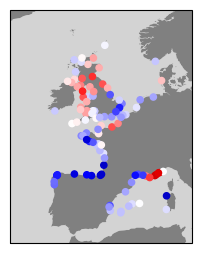

In [19]:
import cartopy
fig=plt.figure(figsize=(8,8)) #generate figure  
gs = fig.add_gridspec(1,3)


#1991-2020
ax = plt.subplot(gs[0,0],projection=ccrs.Robinson(central_longitude=0))

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

sc=ax.scatter(pr.lon,pr.lat,c=np.sum(fut_tracks_per_extreme>1,axis=-1)/fut_peak_in_winter-np.sum(hist_tracks_per_extreme>1,axis=-1)/hist_peak_in_winter,cmap='seismic',vmin=-.2,vmax=.2,s=20,transform=ccrs.PlateCarree(),zorder=3)
ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

In [11]:
fut_peak_in_winter

array([134., 154.,  84., 154., 151., 146., 150., 139., 108.,  99., 154.,
       141., 146., 130., 157., 108., 188., 150., 150., 139., 149., 100.,
       142., 137., 120., 149., 154.,  64., 130.,  78., 208., 154., 150.,
        83., 170., 139., 136., 133., 145., 139.,  90., 148., 142., 137.,
       150., 177., 137.,  85., 149.,  84., 142., 177., 153.,  85., 137.,
       100., 142., 151., 138.,  85., 139., 149., 142.,  92., 146., 149.,
       102., 154., 154., 132., 170., 163., 171.,  81.,  64.,  78., 161.,
       141., 149., 148., 150., 163., 145., 170., 146., 170., 150., 163.,
       147.,  68., 144., 153.,  99., 141., 144., 134., 146., 139., 151.,
        83., 150., 151., 150., 132., 152., 137., 140., 139., 172.])

In [73]:
''' 
y1 = np.array([1979,2040,2050,2060,2070,2080,2090])
y2 = np.array([2014,2049,2059,2069,2079,2089,2099])

vort_thresholds = np.zeros(len(y1))
#determine vorticity thresholds                       
for p in np.arange(len(y1)):
    years = np.arange(y1[p],y2[p]+1)
    vort_peaks = np.array([])        
    for y,year in enumerate(years):
        if year<2015:
            file = '/home/jovyan/CMIP6cf/Priestley_tracks/historical/MRI-ESM2-0/MRI-ESM2-0_'+str(year)+str(year+1)+'_TRACKS_FILTERED_pos.addmslp'
        elif year>=2015:
            file = '/home/jovyan/CMIP6cf/Priestley_tracks/ssp585/MRI-ESM2-0/MRI-ESM2-0_'+str(year)+str(year+1)+'_TRACKS_FILTERED_pos.addmslp'

        if os.path.exists(file):
            with open(file, "r" ) as source:
                for t,heading_and_lines in enumerate(group_by_heading( source )): #for each storm track

                    heading= heading_and_lines[0]
                    lines = heading_and_lines[1:-1]
                    #print(heading)

                    if t>0:
                        vort_peaks = np.append(vort_peaks,np.max(np.array([float(k.split(' ')[3]) for k in lines])))
    vort_thresholds[p] = np.percentile(vort_peaks,90)
    
    
'''    
years = np.arange(1950,2101)
num_tracks = np.zeros((len(years),len(qLONS.flatten())))

for y,year in enumerate(years):
    if year<2015:
        file = '/home/jovyan/CMIP6cf/Priestley_tracks/historical/MRI-ESM2-0/MRI-ESM2-0_'+str(year)+str(year+1)+'_TRACKS_FILTERED_pos.addmslp'
    elif year>=2015:
        file = '/home/jovyan/CMIP6cf/Priestley_tracks/ssp585/MRI-ESM2-0/MRI-ESM2-0_'+str(year)+str(year+1)+'_TRACKS_FILTERED_pos.addmslp'
    
    

    if os.path.exists(file):
        with open(file, "r" ) as source:
            has_tracks = 0
            for t,heading_and_lines in enumerate(group_by_heading( source )): #for each storm track
    
                heading= heading_and_lines[0]
                lines = heading_and_lines[1:-1]
                
                if t>0:
                    times = np.array([float(k.split(' ')[0]) for k in lines])
                    track_lons = np.array([((float(k.split(' ')[1]) +180)%360)-180 for k in lines])
                    track_lats = np.array([float(k.split(' ')[2]) for k in lines])
                    
                    distances = 2*np.arcsin( np.sqrt(
                        np.sin( (np.pi/180) * 0.5*(test.lat.values-lat) )**2 +
                        np.cos((np.pi/180)*lat)*np.cos((np.pi/180)*test.lat.values)*np.sin((np.pi/180)*0.5*(test.lon.values-lon))**2) ) #test distances track to 0, 50
                    
                    '''
                    qlat = np.transpose(np.matlib.repmat(qLATS.flatten(),len(track_lats),1))
                    lat = np.matlib.repmat(track_lats,len(qLATS.flatten()),1)

                    qlon = np.transpose(np.matlib.repmat(qLONS.flatten(),len(track_lons),1))
                    lon = np.matlib.repmat(track_lons,len(qLONS.flatten()),1)
         
                    #calculate distances between track coordinates and grid points
                    distances = 2*np.arcsin( np.sqrt(
                        np.sin( (np.pi/180) * 0.5*(qlat-lat) )**2 +
                        np.cos((np.pi/180)*lat)*np.cos((np.pi/180)*qlat)*np.sin((np.pi/180)*0.5*(qlon-lon))**2) ) #test distances track to 0, 50
                    '''
                    #print(distances)
                    #t0 = np.min(np.matlib.repmat(times,len(qLONS.flatten()),1)[distances<=(2*np.pi*5/360)])
                    #t1 = np.max(np.matlib.repmat(times,len(qLONS.flatten()),1)[distances<=(2*np.pi*5/360)])
                   
                    conds = np.where( (distances<=(2*np.pi*5/360)) & (times>=timesteps[0]) & (times<=timesteps[-1]) )
                    if ~np.isempty(conds):
                        has_track = has_track += 1
                
                    #num_tracks[y,...] = num_tracks[y,...] + np.any(distances<=(2*np.pi*5/360),axis=1)
    else:
        num_tracks[y,...] = num_tracks[y,...]*np.nan
'''
'''       
               
ax.pcolor(qLONS,qLATS,np.reshape(num_tracks,qLONS.shape),transform=ccrs.PlateCarree())
ax.scatter(0,50,s=30,color='black',transform=ccrs.PlateCarree(),zorder=5)
#(dvar_fut-dvar_hist).plot(transform=ccrs.PlateCarree(),cmap='seismic')
ax.set_extent([-20,10, 35, 70], crs=ccrs.PlateCarree())


#spherical cap 5 degrees, i.e., km distance from point to track should be leq 5/360 of circumference Earth

ax.coastlines()
fig.show()
'''


AttributeError: 'NoneType' object has no attribute 'extend'

In [76]:
lines

['1 240.942871 12.265805 2.420871e+00 & 2.409194e+02 & 1.063848e+01 & 1.009734e+03 & \n',
 '2 239.558792 12.217918 2.465939e+00 & 2.403165e+02 & 1.110061e+01 & 1.012603e+03 & \n',
 '3 239.039749 12.303664 2.588607e+00 & 2.391297e+02 & 1.115052e+01 & 1.010365e+03 & \n',
 '4 238.412811 12.511642 2.727921e+00 & 2.380464e+02 & 1.121226e+01 & 1.012688e+03 & \n',
 '5 237.487228 12.682990 2.884296e+00 & 2.369750e+02 & 1.111175e+01 & 1.009035e+03 & \n',
 '6 236.287109 12.778480 2.870745e+00 & 2.363141e+02 & 1.158080e+01 & 1.011979e+03 & \n',
 '7 234.909943 12.953171 2.797750e+00 & 2.352646e+02 & 1.157790e+01 & 1.009417e+03 & \n',
 '8 233.796265 13.116841 2.804353e+00 & 2.343358e+02 & 1.178209e+01 & 1.012621e+03 & \n',
 '9 233.052307 13.267883 2.950003e+00 & 2.334899e+02 & 1.159445e+01 & 1.009426e+03 & \n',
 '10 232.120804 13.201329 2.944566e+00 & 2.326414e+02 & 1.170771e+01 & 1.012423e+03 & \n',
 '11 231.176102 13.288947 2.984280e+00 & 2.316349e+02 & 1.171931e+01 & 1.010032e+03 & \n',
 '12 230

In [157]:
da = xr.DataArray(
    data=np.reshape(num_tracks,(151,len(query_lons),len(query_lats))),
    dims=["year", "lon", "lat"],
    coords=dict(
        lon=query_lats,
        lat=query_lons,
        year = years,
    ),
)



/tmp/ipykernel_1685/2991154415.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ((da.sel(year=slice('2080','2100')).mean(dim='year')-da.sel(year=slice('1979','2014')).mean(dim='year'))).plot(ax=ax,transform=ccrs.PlateCarree(),cmap=matplotlib.cm.get_cmap('RdBu_r'),vmin=-6,vmax=6)


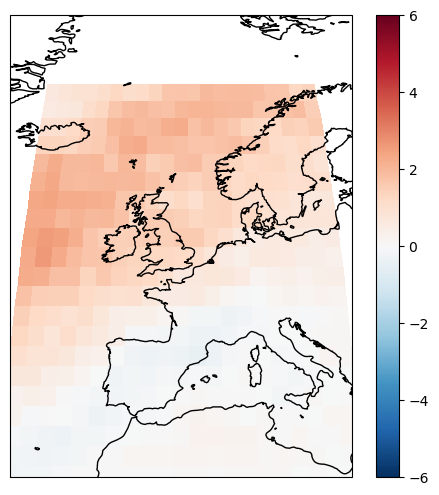

In [158]:

fig=plt.figure(figsize=(6,6)) #generate figure  
gs = fig.add_gridspec(1,1)


ax = plt.subplot(gs[0,0],projection=ccrs.Robinson(central_longitude=0))

((da.sel(year=slice('2080','2100')).mean(dim='year')-da.sel(year=slice('1979','2014')).mean(dim='year'))).plot(ax=ax,transform=ccrs.PlateCarree(),cmap=matplotlib.cm.get_cmap('RdBu_r'),vmin=-6,vmax=6)
ax.coastlines()
ax.set_extent([-20,20, 30, 80], crs=ccrs.PlateCarree())


In [5]:
wind = xr.open_dataset('/home/jovyan/CMIP6cf/output/sfcWind_timeseries/MRI-ESM2-0/MRI-ESM2-0_gn_day_ssp585.nc')
tracks = pd.read_csv('/home/jovyan/CMIP6cf/Priestley_tracks/ssp585/MRI-ESM2-0/MRI-ESM2-0_20152016_TRACKS_FILTERED_pos.addmslp')

In [61]:
heading_and_lines

['POINT_NUM  9\n',
 '355 107.432411 27.675098 3.295905e+00 & 1.050559e+02 & 2.726971e+01 & 1.008803e+03 & \n',
 '356 108.091812 27.849272 3.613588e+00 & 1.072120e+02 & 2.635683e+01 & 1.011125e+03 & \n',
 '357 110.165665 28.490355 3.619922e+00 & 1.095368e+02 & 2.490385e+01 & 1.012908e+03 & \n',
 '358 113.177345 28.676449 3.390504e+00 & 1.176884e+02 & 2.625088e+01 & 1.011708e+03 & \n',
 '359 115.224701 28.179775 3.566714e+00 & 1.180107e+02 & 2.593464e+01 & 1.012770e+03 & \n',
 '360 111.369072 26.611202 3.785322e+00 & 1.124476e+02 & 2.373670e+01 & 1.009292e+03 & \n',
 '361 114.833099 27.425278 4.237567e+00 & 1.173501e+02 & 2.517279e+01 & 1.010064e+03 & \n',
 '362 116.921440 27.153767 4.196634e+00 & 1.000000e+25 & 1.000000e+25 & 1.014606e+03 & \n',
 '363 119.120964 27.422012 3.908162e+00 & 1.000000e+25 & 1.000000e+25 & 1.015381e+03 & \n']

In [4]:

# window length for filters
window = 61

# construct 3 days and 10 days low pass filters
hfw = low_pass_weights(window, 1. / 2.)
lfw = low_pass_weights(window, 1. / 6.)
weight_high = xr.DataArray(hfw, dims = ['window'])
weight_low = xr.DataArray(lfw, dims = ['window'])

# Load the hourly 850hPa vorticity
#fname = '/Users/serene.meng/EAR5_Test/tcseed/vort_850_06_to_11_2016'
#ds = xr.open_dataset(fname)

'''
Results are presented for Jul–Oct although data in June and November
are also needed because the time filter requires extra data at the 
beginning and end of each year’s time series.
'''
#hourly_data = ds.sel(time=slice("2016-06-07T00:00:00","2016-11-24T23:00:00"))['vo']

# Since the EAR5 data are hourly, we first average them into daily data.
#daily_data = hourly_data.resample(time='24H').mean(dim = 'time')

# apply the filters using the rolling method with the weights
lowpass_hf = daily_data_hist.rolling(time = len(hfw), center = True).construct('window').dot(weight_high)
lowpass_lf = daily_data_hist.rolling(time = len(lfw), center = True).construct('window').dot(weight_low)

# the bandpass is the difference of two lowpass filters.
bandpass = lowpass_hf - lowpass_lf

'''
Okay, here I calculate the variance of 3-10 day bandpass filtered
850hPa vorticity (Jul to Oct), which could be defined as
TC seed index:  "pre-TC synoptic-scale disturbances"
References
----------
Li, T., Kwon, M., Zhao, M., Kug, J.S., Luo, J.J. and Yu, W., 2010.
Global warming shifts Pacific tropical cyclone location.
Geophysical Research Letters, 37(21).
'''
#dvar_hist = xr.DataArray.var(bandpass, dim = 'time', skipna = True)
rms_hist = (bandpass**2).mean(dim='time')**.5

####
# apply the filters using the rolling method with the weights
lowpass_hf = daily_data_fut.rolling(time = len(hfw), center = True).construct('window').dot(weight_high)
lowpass_lf = daily_data_fut.rolling(time = len(lfw), center = True).construct('window').dot(weight_low)

# the bandpass is the difference of two lowpass filters.
bandpass = lowpass_hf - lowpass_lf

'''
Okay, here I calculate the variance of 3-10 day bandpass filtered
850hPa vorticity (Jul to Oct), which could be defined as
TC seed index:  "pre-TC synoptic-scale disturbances"
References
----------
Li, T., Kwon, M., Zhao, M., Kug, J.S., Luo, J.J. and Yu, W., 2010.
Global warming shifts Pacific tropical cyclone location.
Geophysical Research Letters, 37(21).
'''
#dvar_fut = xr.DataArray.var(bandpass, dim = 'time', skipna = True)
rms_fut = (bandpass**2).mean(dim='time')**.5



#https://github.com/liv0505/Lanczos-Filter/blob/master/lanczosbp.py

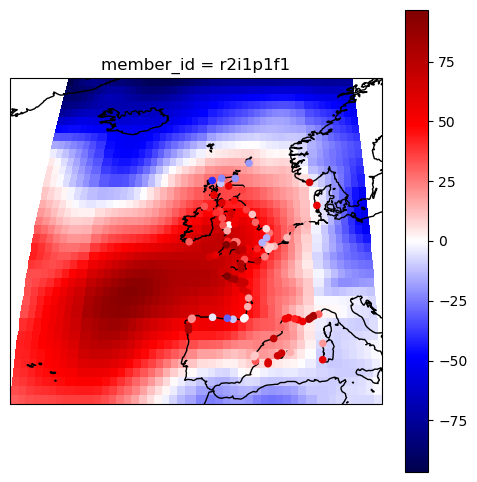

In [5]:
import cartopy
fig=plt.figure(figsize=(6,6)) #generate figure  
gs = fig.add_gridspec(1,1)


ax = plt.subplot(gs[0,0],projection=ccrs.Robinson(central_longitude=0))


#(dvar_fut-dvar_hist).plot(transform=ccrs.PlateCarree(),cmap='seismic')
(rms_fut-rms_hist).plot(transform=ccrs.PlateCarree(),cmap='seismic')
#ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())


ax.coastlines()




#a little test
timesteps = xr.DataArray(data=np.arange(len(dep.window)),dims=['window'],coords=dict(window=dep.window))
ssp_ds = dep.num_co_occurring.isel(month=0)
slope = (1/np.diff(dep.window)[0])*xr.corr(ssp_ds,timesteps,dim='window')*ssp_ds.std(dim='window')/timesteps.std(dim='window')
#sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*ssp_ds_diff.mean(dim='member_id').mean(dim='source_id'),cmap='seismic',vmin=-10,vmax=10,s=20,transform=ccrs.PlateCarree(),zorder=3)
sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*slope,cmap='seismic',vmin=-.05,vmax=.05,s=20,transform=ccrs.PlateCarree(),zorder=3)

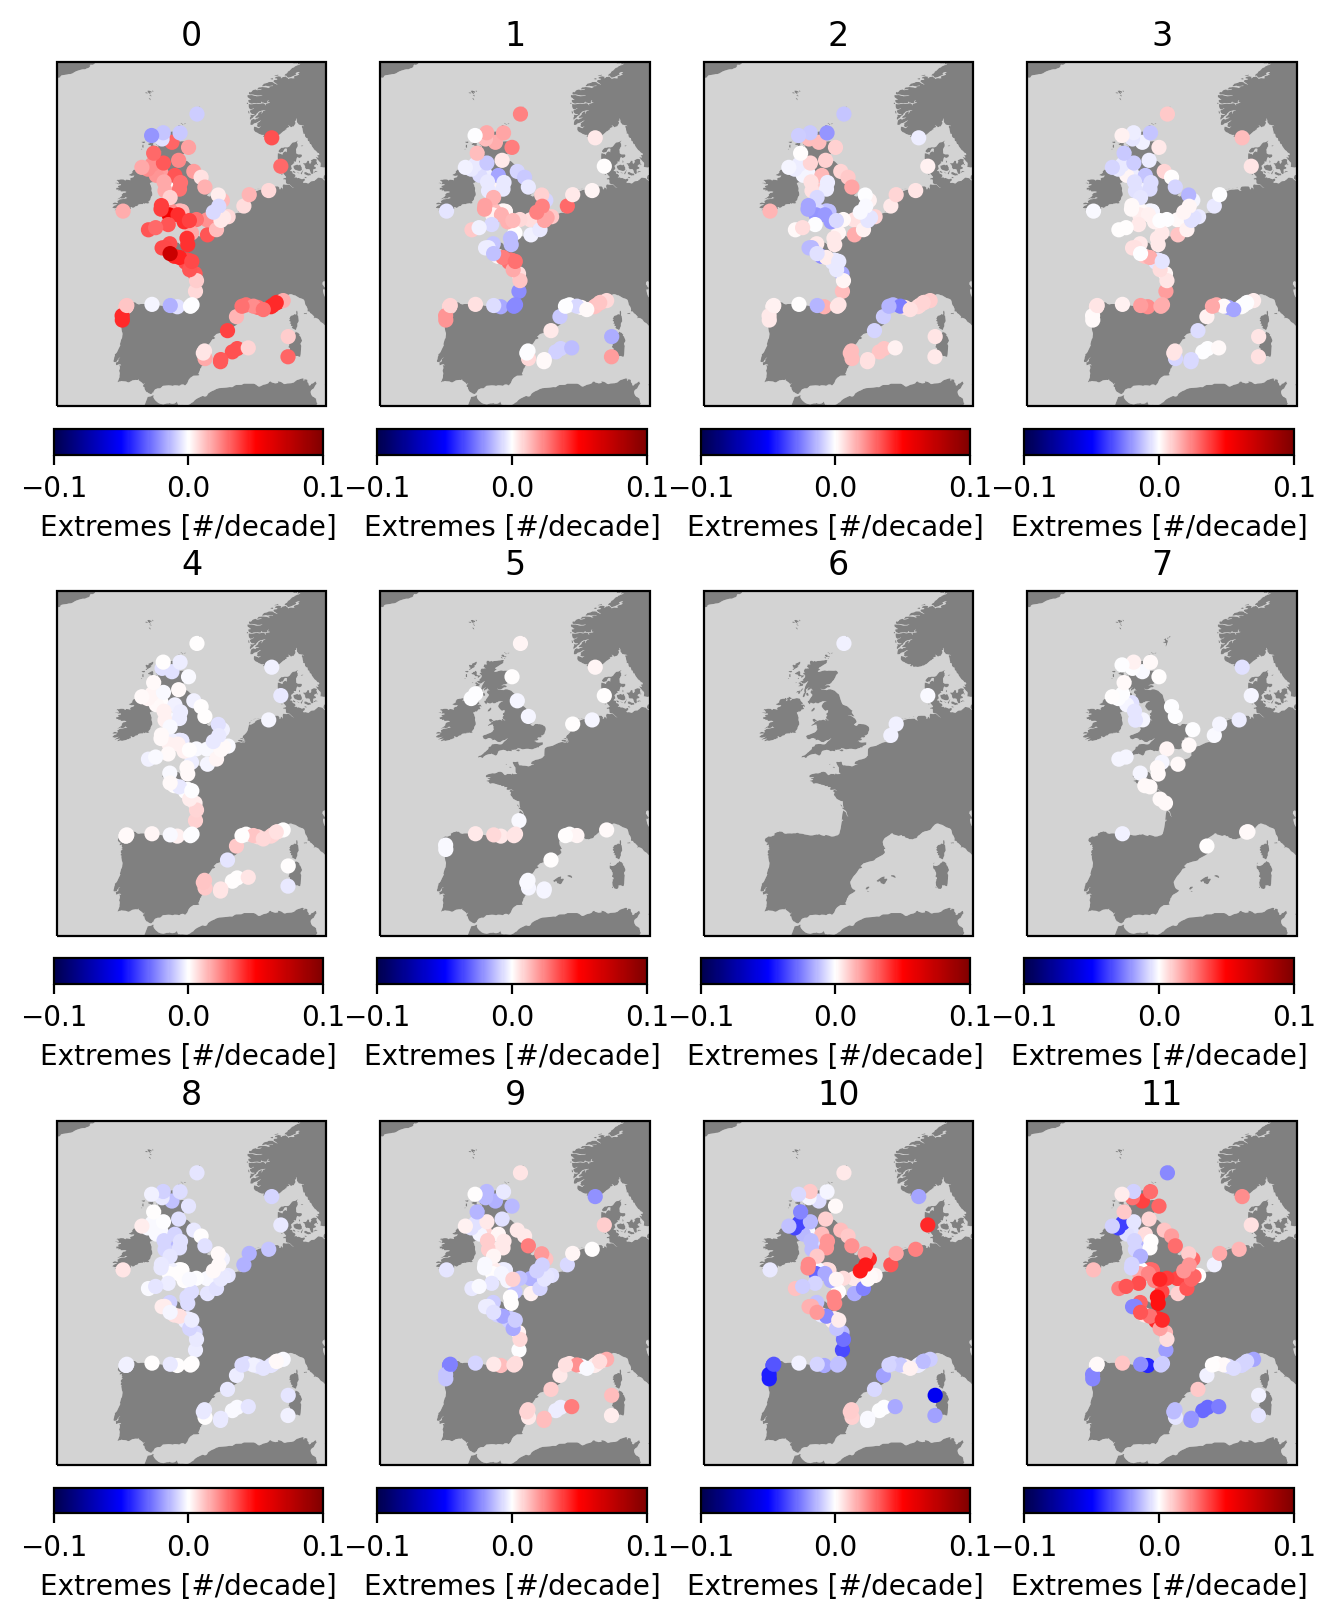

In [6]:

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%config InlineBackend.figure_format = 'retina'


timesteps = xr.DataArray(data=np.arange(len(dep.window)),dims=['window'],coords=dict(window=dep.window))

fig=plt.figure(figsize=(8,10)) #generate figure  
gs = fig.add_gridspec(3,4)
gs.update(wspace=.2,hspace=.1)
    
ssp='ssp585'
for m,month in enumerate(np.arange(12)):
    ssp_ds = dep.num_co_occurring.isel(month=m)

    ssp_ds_present = ssp_ds.sel(window=2000)#.sel(window=2005)
    ssp_ds_future = ssp_ds.sel(window=2080)#.sel(window=2085)
    ssp_ds_diff = (ssp_ds_future - ssp_ds_present)
    
    #1991-2020
    ax = plt.subplot(gs[np.unravel_index(m,(3,4))],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    slope = (1/np.diff(dep.window)[0])*xr.corr(ssp_ds,timesteps,dim='window')*ssp_ds.std(dim='window')/timesteps.std(dim='window')
    #sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*ssp_ds_diff.mean(dim='member_id').mean(dim='source_id'),cmap='seismic',vmin=-10,vmax=10,s=20,transform=ccrs.PlateCarree(),zorder=3)
    sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*slope,cmap='seismic',vmin=-.1,vmax=.1,s=20,transform=ccrs.PlateCarree(),zorder=3)
    ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

   
    cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
    cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='Extremes [#/decade]')
    
    ax.set_title(str(m))

  
#meaning of number of joint extremes?

#fig.savefig('Figures/ensmean_num_joint_extremes_knmi.pdf',format='pdf',dpi=300,bbox_inches='tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.05, 0.9, 'b)')

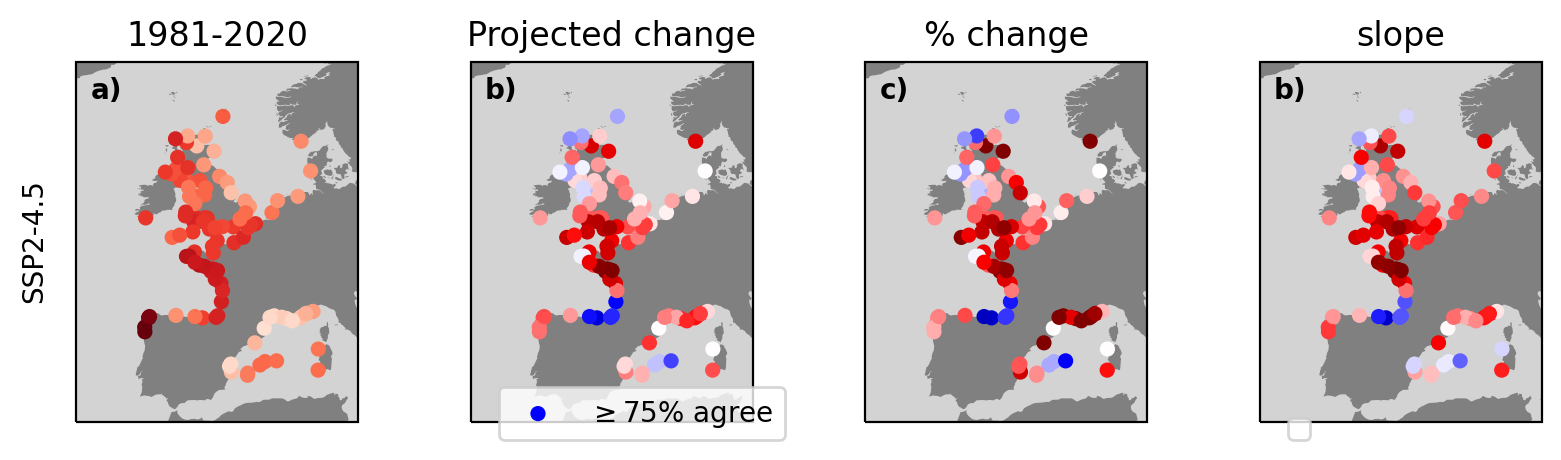

In [7]:
fig=plt.figure(figsize=(12,5)) #generate figure  
gs = fig.add_gridspec(2,5)
gs.update(wspace=.4,hspace=.1)
    
s=0
ssp_ds = dep.num_co_occurring.isel(month=-1) + dep.num_co_occurring.isel(month=0) + dep.num_co_occurring.isel(month=1)

ssp_ds_present = ssp_ds.sel(window=2000)#.sel(window=2005)
ssp_ds_future = ssp_ds.sel(window=2080)#.sel(window=2085)
ssp_ds_diff = ssp_ds_future - ssp_ds_present

#1991-2020
ax = plt.subplot(gs[0,0],projection=ccrs.Robinson(central_longitude=0))

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*ssp_ds_present,cmap='Reds',vmin=0,vmax=30,s=20,transform=ccrs.PlateCarree(),zorder=3)
ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

if s==1:
    cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
    cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='Extremes [#/decade]')
if s==0:
    ax.set_title('1981-2020')

ax.annotate(['SSP2-4.5','SSP5-8.5'][s],(-.2,.35),xycoords='axes fraction',rotation=90)
ax.annotate('ad'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')

ax = plt.subplot(gs[0,1],projection=ccrs.Robinson(central_longitude=0))

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')


diff = ssp_ds_diff


sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*ssp_ds_diff,cmap='seismic',vmin=-10,vmax=10,s=20,transform=ccrs.PlateCarree(),zorder=3,label='$\geq$75% agree')

ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

if s==0:
    ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
    ax.set_title('Projected change')
if s==1:

    cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
    cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Extremes [#/decade]')
ax.annotate('be'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')    

ax = plt.subplot(gs[0,2],projection=ccrs.Robinson(central_longitude=0))

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=(100*ssp_ds_diff/ssp_ds_present),cmap='seismic',vmin=-50,vmax=50,s=20,transform=ccrs.PlateCarree(),zorder=3)
ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

if s==1:
    cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
    cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Extremes [%]')
if s==0:
    ax.set_title('% change')
ax.annotate('cf'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')
#meaning of number of joint extremes?

#fig.savefig('Figures/ensmean_num_joint_extremes_knmi.pdf',format='pdf',dpi=300,bbox_inches='tight')



ax = plt.subplot(gs[s,3],projection=ccrs.Robinson(central_longitude=0))

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')


slope = (1/np.diff(ssp_ds.window)[0])*xr.corr(ssp_ds,timesteps,dim='window')*ssp_ds.std(dim='window')/timesteps.std(dim='window')
sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*slope,cmap='seismic',vmin=-.1,vmax=.1,s=20,transform=ccrs.PlateCarree(),zorder=3)

ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

if s==0:
    ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
    ax.set_title('slope')
if s==1:

    cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
    cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Extremes [#/decade]')
ax.annotate('be'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')    

In [8]:
dep

<xarray.Dataset>
Dimensions:             (tg: 109, window: 11, quantile: 10, extreme_variate: 3,
                         statistic: 2, estimator: 2, month: 12)
Coordinates: (12/13)
    gridcell_lat        (tg) float64 ...
    gridcell_lon        (tg) float64 ...
    member_id           <U8 'r2i1p1f1'
  * tg                  (tg) object 'arcachon_eyrac_.csv' ... 'gijon_gijon_sp...
    lat                 (tg) float64 44.66 47.31 41.34 47.29 ... 50.1 51.7 43.56
    lon                 (tg) float64 -1.164 -2.108 2.163 ... -5.014 -5.698
    ...                  ...
  * window              (window) int64 1880 1900 1920 1940 ... 2040 2060 2080
  * quantile            (quantile) float64 0.9 0.91 0.92 0.93 ... 0.97 0.98 0.99
  * month               (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * extreme_variate     (extreme_variate) object 'sfcWind' 'pr' 'both'
  * statistic           (statistic) object 'coef' 'p'
  * estimator           (estimator) object 'cfg' '.95'
Data variables:
    ktau                (extreme_variate, window, tg, statistic) float64 ...
    utdc                (estimator, window, tg, statistic) float64 ...
    complete_window     (window, tg) bool ...
    num_co_occurring    (month, window, tg) float64 ...
    sfcWind_thresholds  (quantile, window, tg) float64 ...
    pr_thresholds       (quantile, window, tg) float64 ...
Attributes: (12/67)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            0.0
    cmor_version:                     3.5.0
    ...                               ...
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.MPI-M.MPI-ESM1-2-HR.historical.r1i...
    original_key:                     MPI-ESM1-2-HR.gn.historical.day.r1i1p1f1
    window_length:                    40
    declustering:                     Rolling window of 3 days
    allowed_lag:                      2